# N対シミュレーション

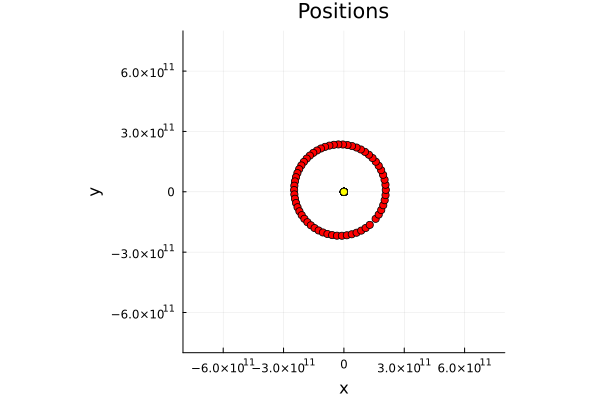

┌ Info: Saved animation to /Users/shim/Desktop/Code/dev/Asteroid/Julia/tankyu/animation.gif
└ @ Plots /Users/shim/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/shim/Desktop/Code/dev/Asteroid/Julia/tankyu/animation.gif")
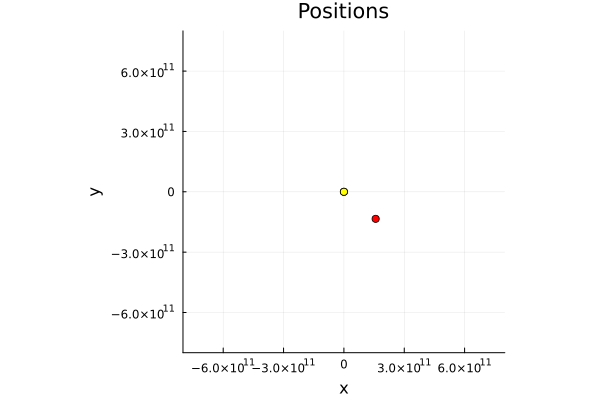

In [8]:
using LinearAlgebra
using Statistics
using Plots
using FFMPEG

gr()

# 加速度を取得
function getAcc(pos, mass , G)
    x = pos[:,1,1]
    y = pos[:,2,1]
    z = pos[:,3,1]

    #天体間の距離
    dx = x' .- x
    dy = y' .- y
    dz = z' .- z

    #距離の3乗の逆数
    inv_r3 = (dx.^2 .+ dy.^2 .+ dz.^2 .+ 0.1).^(-1.5)

    #加速度
    ax = G * (dx .* inv_r3) * mass
    ay = G * (dy .* inv_r3) * mass
    az = G * (dz .* inv_r3) * mass

    #連結
    return hcat(ax,ay,az)
end

# エネルギーを取得
function getEnergy(pos, vel, mass, G)
    #運動エネルギーの総和
    KE = 0.5 * sum(sum(mass .* vel^2))

    x = pos[:,1,1]
    y = pos[:,2,1]
    z = pos[:,3,1]
    dx = x' .- x
    dy = y' .- y
    dz = z' .- z 
    
    inv_r = (dx.^2 .+ dy.^2 .+ dz.^2) .^ (0.5)
    inv_r[inv_r .> 0] = 1.0 ./ inv_r[inv_r .> 0]
    PE = G * sum(sum(triu(-(mass * mass')*inv_r,1)))

    return KE, PE

end

function main()
    # 時間:s
    # 質量:kg 
    # 距離:m

    t = 0.0
    tEnd = 60.0 * 60.0 * 24.0 * 680.0 #1火星年
    dt = 60.0 * 60.0 #1時間
    G = 6.674e-11
    mass = [
        1.988e30
        6.416e23
        1.898e27
    ]
    pos = [
        0.0 0.0 0.0
        0.9393652962242416 -1.0254610575824845 -0.04453588682426547
        0.0 7.783e11 0.0
    ] .* 1.495978e11 #天文単位
    vel = [
        0.0 0.0 0.0
        18780.930434211026 18440.38268808071 -74.18055640321288
        13.06e3 0.0 0.0
    ]
    vel .-= mean(mass .* vel) / mean(mass)
    
    acc = getAcc(pos, mass, G)
    
    KE,PE = getEnergy(pos, vel, mass, G)
    
    Nt = Int(ceil(tEnd/dt))
    
    pos_save = zeros((3,3,Nt+1))
	pos_save[:,:,1] = pos
	KE_save = zeros(Nt+1)
	KE_save[1] = KE
	PE_save = zeros(Nt+1)
	PE_save[1] = PE
    
    vel_save = zeros(Nt+1)
    
    vel2_save = zeros(Nt+1)
    
    for i in 1:Nt
		vel += acc * dt/2.0
		pos += vel * dt
		acc = getAcc( pos, mass, G)
		vel += acc * dt/2.0
		t += dt
        
        KE, PE  = getEnergy( pos, vel, mass, G )
        pos_save[:,:,i+1] = pos
		KE_save[i+1] = KE
		PE_save[i+1] = PE
    end
    
    p = scatter([0], [0], xlims=(-8.0e11,8.0e11), ylims=(-8.0e11,8.0e11), title="Positions", xlabel="x", ylabel="y", aspect_ratio=:equal, legend=false)
    al = Int(Nt/60.0)
    anim = @animate for frame in 1:60
        for i in 1:2
            x = pos_save[i,1,frame*al]
            y = pos_save[i,2,frame*al]
            scatter!(p, [x], [y], color=colors[i])
        end
    end

    display(p)
    gif(anim, "animation.gif", fps=10)

end

colors = [:yellow, :red, :"#ff8888"]

main()
